In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from itertools import combinations_with_replacement
from functools import reduce
from operator import mul
from math import factorial
import einops
from koopman.simulation.simulator import simulate, simulate_batch
from koopman.simulation.systems import DynamicalSystem, NonlinearAttractor2D
from koopman.edmd.edmd import eDMD
from sklearn.preprocessing import PolynomialFeatures
from spatialmath.base import angle_wrap
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import PolynomialFeatures

def get_random_visible_color():
    # Sample hue randomly, fix saturation and value for vibrancy
    h = np.random.rand()           # Hue ∈ [0, 1]
    s = np.random.uniform(0.6, 1)  # Saturation: avoid pale colors
    v = np.random.uniform(0.7, 1)  # Value (brightness): avoid dark
    return mcolors.hsv_to_rgb((h, s, v))

In [50]:
# Run a simulation with the NonlinearAttractor2D system
attractor = NonlinearAttractor2D(NonlinearAttractor2D.Params(mu=2.0, lam=-0.5))

N = 1000
x0 = np.random.uniform(-10, 10, (N, 2))
tf = 5.0
dt = 0.05
T = int(tf/dt)
controls = np.random.randn(N, T, 1) * 5.0

ts, xhist, uhist = simulate_batch(
    sys=attractor,
    tf=tf,
    dt=dt,
    u=controls,
    x0=x0
)

print(f"Simulation finished. {xhist.shape=}, {uhist.shape=}")

Simulation progress: 100%|██████████| 100/100 [00:00<00:00, 13372.99it/s]

Simulation finished. xhist.shape=(1000, 101, 2), uhist.shape=(1000, 100, 1)


In [51]:
# Hand-pick the observables
def koopman_observables(xhist: np.ndarray) -> np.ndarray:
    is_batched = xhist.ndim == 2
    if not is_batched:
        xhist = np.expand_dims(xhist, axis=0)
    
    x1, x2 = xhist[:, 0], xhist[:, 1]
    
    Y = np.column_stack([
        x1 ** 2,
    ])
    
    out = np.concatenate([xhist, Y], axis=-1)
    
    if not is_batched:
        return np.squeeze(out, axis=0)
    else:
        return out

# Fit the eDMD model to the data using the observable
edmd = eDMD()
zhist = edmd.apply_observable_to_history(xhist, koopman_observables)
_ = edmd.fit(zhist , uhist, bilinear=False)

Fitting EDMD model with data:
	zhist.shape=(1000, 101, 3)
	uhist.shape=(1000, 100, 1)
	# of trajectories: 1000
	# of time steps: 101
	# of lifted states: 3
	# of controls: 1
Fitting results:
	self.kpA.shape=(3, 3)
	self.kpB.shape=(3, 1)
	A condition number: 1.2540503440917181
	B condition number: 1.0


Simulation progress: 100%|██████████| 100/100 [00:00<00:00, 39457.23it/s]

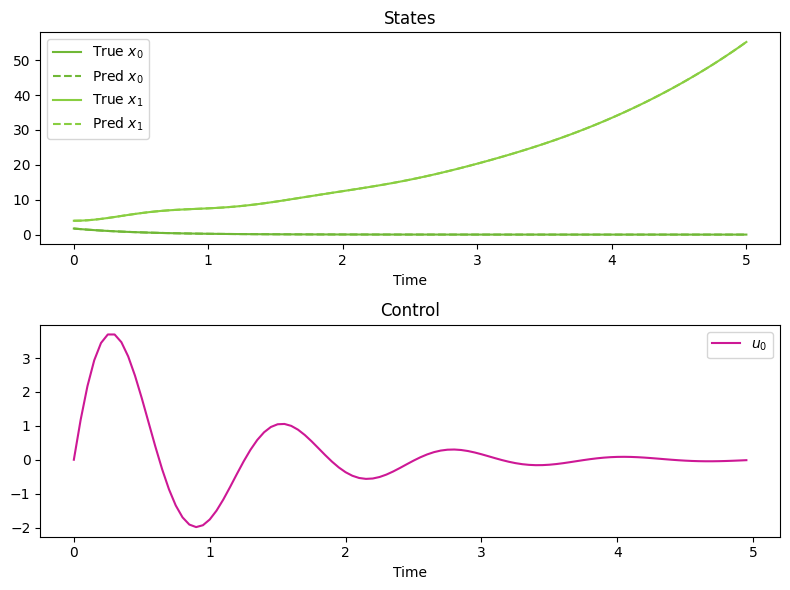

In [52]:
# Evaluate the model on some new data
x0 = np.random.uniform(-10, 10, 2)

ts = np.arange(0, tf, dt)
controls = (5*np.exp(-ts) * np.sin(5 * ts)).reshape((T, -1)) #np.ones((T, NonlinearAttractor2D.nu)) #np.squeeze(generate_random_smooth_controls(1, int(tf/dt)), axis=0)

eval_ts, eval_xhist, eval_uhist = simulate(
    sys=attractor,
    tf=tf,
    dt=dt,
    u=controls,
    x0=x0
)

# Simulate the system with the learned model
zjm1 = koopman_observables(x0)

eval_xhist_pred = np.empty_like(eval_xhist)
eval_xhist_pred[0] = edmd.project_to_x(zjm1, NonlinearAttractor2D.nx)

for i, t in enumerate(eval_ts[:-1]):
    zj = edmd.predict_z_next(zjm1, controls[i])
    eval_xhist_pred[i + 1] = edmd.project_to_x(zj, NonlinearAttractor2D.nx)
    
    zjm1 = zj

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
for i in range(NonlinearAttractor2D.nx):
    color = get_random_visible_color()
    ax[0].plot(eval_ts, eval_xhist[:, i], color=color, label=fr"True $x_{i}$")
    ax[0].plot(eval_ts, eval_xhist_pred[:, i], color=color, linestyle='--', label=fr"Pred $x_{i}$")
    
ax[0].set_title("States")
ax[0].set_xlabel("Time")
ax[0].legend()

for i in range(NonlinearAttractor2D.nu):
    color = get_random_visible_color()
    ax[1].plot(eval_ts[:-1], eval_uhist[:, i], color=color, label=rf"$u_{i}$")

ax[1].set_title("Control")
ax[1].set_xlabel("Time")
ax[1].legend()

plt.tight_layout()
plt.show()

In [56]:
print("A Matrix:")
print(repr(edmd.kpA))

print("B Matrix:")
print(repr(edmd.kpB))

A Matrix:
array([[ 9.04837500e-01, -1.84653183e-19,  1.73499148e-18],
       [-2.64816381e-17,  1.02531512e+00, -2.29538642e-02],
       [ 1.77369996e-16, -5.64613644e-16,  8.18730901e-01]])
B Matrix:
array([[-6.55179985e-19],
       [ 5.06302409e-02],
       [ 3.88921530e-16]])
